In [1]:
import pandas as pandas
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

/var/folders/c2/l58_pxzx2tqb1lr7wlj_xt7h0000gn/T/ipykernel_6272/1603370065.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pandas


In [2]:
def check_stability(D, dt, dx):
    """
    Check the stability condition for the diffusion equation and raise an error if unstable.

    :param D: The diffusion coefficient.
    :param dt: The time step.
    :param dx: The space step.
    """
    if (4 * D * dt) / (dx**2) > 1:
        raise ValueError("The given parameters will result in an unstable solution. "
                         "Stability condition violated: (4Ddt/dx^2) should be <= 1. "
                         "Please use a smaller time step or a larger space step.")

    
def generate_time_steps(T, dt):
    return np.arange(0, T+dt, dt)

def init_concentration_matrix(x,y,t):
    return np.zeros((x,y,t), dtype=float)

def init_concentration_matrix_2d(x,y):
    return np.zeros((x,y), dtype=float)


## 1.1 Vibrating String

#### A  
Discretize the wave equation, and write it in a form suitable for implementing in a computer program. Assume that the boundaries are fixed, Ψ(x = 0,t) = 0, Ψ(x = L,t) = 0. L is the length of the string. Take L = 1 for simplicity. Divide the string in N intervals, so that the interval length is ∆x = L/N. Also consider the boundary cases.

#### B  

Function to simulate the vibrating string using euler step for the first time step and finite difference method for further evolution.\
**Boundary conditions**: $\psi(x = 0, t)$ = 0 and $\psi(x = L,t)$ = 0.

In [3]:
def simulate_vibrating_string(c, L, T, dt, dx, dphi_dx, x_0):
    """
    Simulate the vibrating string with the given parameters.
    param x_0: The initial displacement of the string.
    param c: The wave speed.
    param L: The length of the string.
    param T: The total time to simulate.
    param dt: The time step.
    param dx: The space step.    
    """ 
    time_steps = np.arange(0, T+dt, dt)
    x = np.zeros((len(x_0), len(time_steps)), dtype=float) # Create an array to store the results.
    x[:,0] = x_0
    # euler step to find the next time step.
    x[1:-1,1] = x_0[1:-1] + c * dt * dphi_dx[1:-1]

    # stepping method to find the next time steps.
    for j in range(2, len(time_steps)):
        x[1:-1, j] = 2*x[1:-1, j-1] - x[1:-1, j-2] + c**2 * (dt/dx)**2 * (x[2:, j-1] + x[0:-2, j-1] - 2*x[1:-1,j-1])

    return x
    

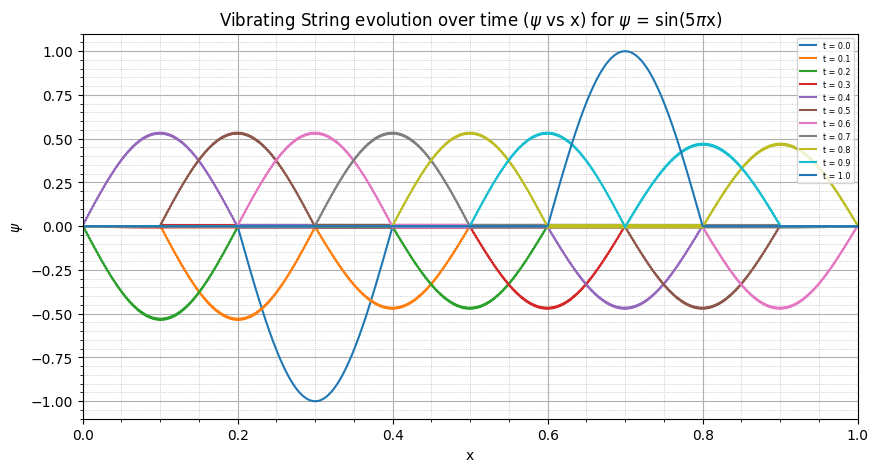

In [4]:
# define the parameters
c = 1
L = 1
T = 1
dt = 0.001
N = 1000
dx = L/N

# define the wave equation.

n = 5 # 'n' in wave equation sin(n*pi*x)
#x_0 = np.sin(n * np.pi * np.arange(0, L, dx))
x_0 = np.array([np.sin(n * np.pi * x) if 1/5 < x < 2/5 else 0 for x in np.arange(0, L+dx, dx)])
dphi_dx = np.array([np.cos(n * np.pi * x) if 1/5 < x < 2/5 else 0 for x in np.arange(0, L+dx, dx)])
#dphi_dx = np.cos(n * np.pi * np.arange(0, L, dx))

# run simulation
x = simulate_vibrating_string(c, L, T, dt, dx, dphi_dx, x_0)

# Plotting
plt.figure(figsize=(10, 5))
for i,t in enumerate(np.arange(0, T+dt, dt)):
    if i % 100 == 0:
        plt.plot(np.arange(0, L+dx, dx),x[:,i], label='t = {}'.format(round(t,3)))
plt.xlabel('x')
plt.ylabel(r'$\psi$')
plt.title(fr'Vibrating String evolution over time ($\psi$ vs x) for $\psi$ = sin({n}$\pi$x)')
plt.xlim(0, L)
plt.legend(loc = 'upper right', fontsize='xx-small')
plt.grid(True)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.show()

#### C  
Animation

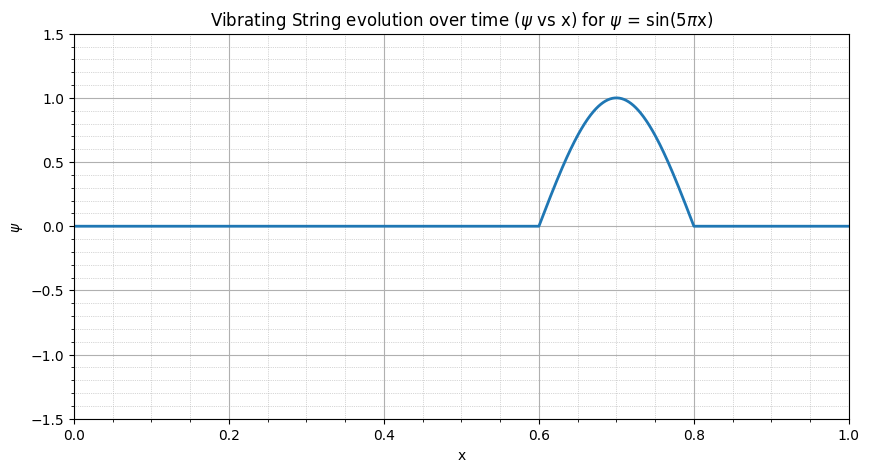

In [4]:
# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 5))
line, = ax.plot([], [], lw=2)
ax.set_xlim(0, L)
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel('x')
ax.set_ylabel(r'$\psi$')
ax.set_title(fr'Vibrating String evolution over time ($\psi$ vs x) for $\psi$ = sin({n}$\pi$x)')
ax.grid(True)
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.5')

# Initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# Animation function: this is called sequentially
def animate(i):
    y = x[:, i]
    line.set_data(np.arange(0, L+dx, dx), y)
    return line,

# Call the animator
ani = FuncAnimation(fig, animate, init_func=init, frames=len(np.arange(0, T+dt, dt)), interval=20, blit=True)

# To save the animation, uncomment the following line
ani.save('string_vibration.mp4', writer='ffmpeg')
#ani.save('string_vibration.gif', writer=PillowWriter(fps=20))

plt.show()


### 1.2 The Time Dependent Diffusion Equation

#### D  

Determine the equation to use at the boundaries of the domain. Clearly show the ranges of the indices of the grid. A figure is extremely helpful for figuring this out.
Write a program for the simulation of the two-dimensional time dependent diffusion equation discretized using the explicit finite difference formulation from eq. (7). You may want to write your data to file (e.g. after every iteration, of maybe after every 100 iterations) so that you can analyze the data later on, or plot it immediately.

#### F

Plot the results, show the 2D domain, with a color representing the concentration at each point. Make a plot of the state of the system at several times: t = {0, 0.001, 0.01, 0.1, and 1}.

In [5]:
def simulate_2D_diffusion(D, L, T, dt, dx, x_0):
    """
    Simulate the 2D diffusion with the given parameters.
    param D: The diffusion coefficient.
    param L: The length of the domain.
    param T: The total time to simulate.
    param dt: The time step.
    param dx: The space step.
    param x_0: The initial concentration.    
    """

    check_stability(D, dt, dx)
    time_steps = generate_time_steps(T, dt)
    x = init_concentration_matrix(len(x_0), len(x_0), len(time_steps))

    x[:,-1,:] = 1 # Set the boundary condition at y=L.
    x[:,0,:] = 0 # Set the boundary condition at y=0.
    x[:,:,0] = x_0 # Set the initial condition.
    
    # Assuming periodic boundary conditions at x=0 and x=L.
    for k in range(1, len(time_steps)):
        x[:, 1:-1, k] = x[:, 1:-1, k-1] + ((D * dt) / (dx**2)) * (np.roll(x[:, 1:-1, k-1],-1,axis=0) + np.roll(x[:, 1:-1, k-1],1,axis=0) + x[:, 2:, k-1] + x[:, 0:-2, k-1] - 4*x[:, 1:-1, k-1])

    return x


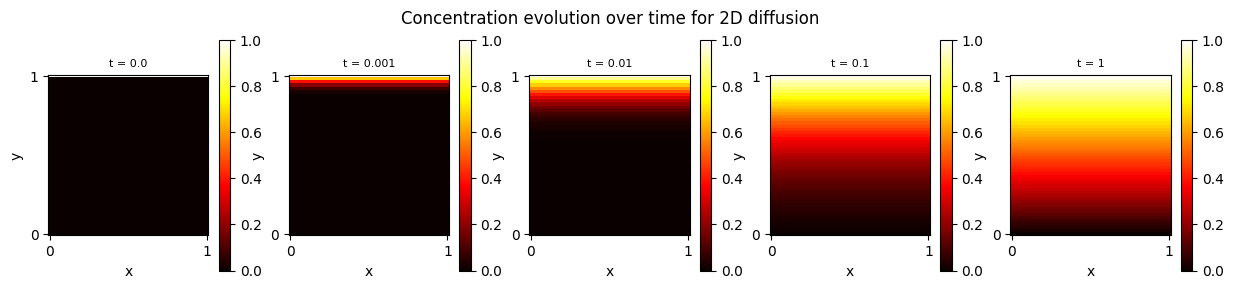

In [6]:
# define the parameters
D = 1
L = 1
T = 1
# need to experiment with the time step and space step to get a stable solution.
dt = 0.0001
N = 50
dx = L/N
x_0 = np.zeros((N+1, N+1), dtype=float)
x_0[:, -1] = 1

x = simulate_2D_diffusion(D, L, T, dt, dx, x_0)

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=5,figsize=(15, 3))
for i,t in enumerate([0.0, 0.001, 0.01, 0.1, 1]):
    im = ax[i].imshow(x[:,:,int(t/dt)].T, cmap='hot', interpolation='nearest', origin='lower')
    fig.colorbar(im, ax=ax[i])
    #fig.colorbar(im, ax=ax[i], label='Concentration'
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('y')
    ax[i].set_xticks([0, N], ['0', str(L)])
    ax[i].set_yticks([0, N], ['0', str(L)])
    ax[i].set_title('t = {}'.format(t), fontsize=8)

fig.suptitle('Concentration evolution over time for 2D diffusion', fontsize=12)
plt.show()


#### E  
Test the correctness of your simulation. Compare to the analytic solutions, plot c(y) for different times. 

In [8]:
def diffusion_2d_analytical(y, t, D, num_terms):
    # can use a stopping criteria to implemnt this.
    """
    Calculate the series solution for the concentration c(y, t).
    param y: position of y coordinate.
    param t: time.
    param D: diffusion coefficient.
    param num_terms : number of terms included in the infinite sum.
    """
    terms = [(erfc((1 - y + 2*i) / (2 * np.sqrt(D * t))) - 
              erfc((1 + y + 2*i) / (2 * np.sqrt(D * t)))) for i in range(num_terms)]
    return sum(terms)

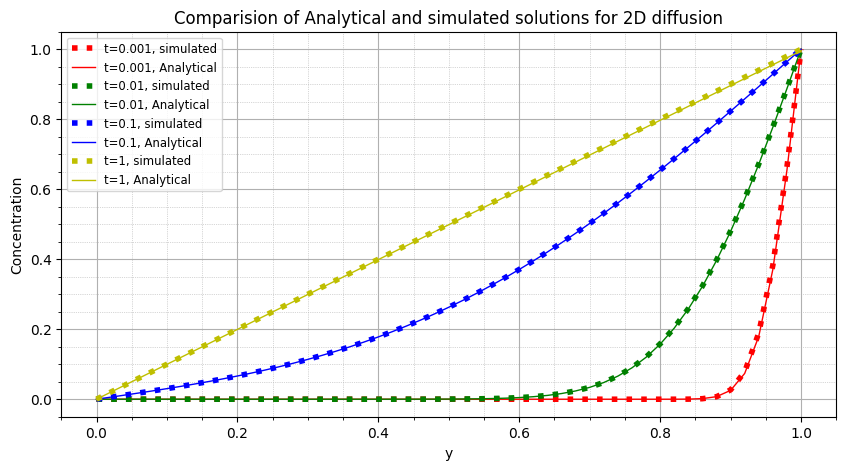

In [9]:
plt.figure(figsize=(10, 5))
colors = ['r', 'g', 'b', 'y']
for i,t in enumerate([0.001, 0.01, 0.1, 1]):
    color = colors[i]
    plt.plot(np.arange(0, L+dx, dx), x[0,:,int(t/dt)], linestyle = 'dotted', label = f't={t}, simulated',color=color, linewidth=4)
    plt.plot(np.arange(0, L+dx, dx), diffusion_2d_analytical(np.arange(0, L+dx, dx), t, D, 2), label = f't={t}, Analytical', color=color, linewidth=1)

plt.legend(fontsize='small')
plt.ylabel('Concentration')
plt.xlabel('y')
plt.title('Comparision of Analytical and simulated solutions for 2D diffusion')
plt.grid(True)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.show()

#### G  
Make an animated plot of the time dependent diffusion equation until equilibrium.

Animation saved as diffusion.gif


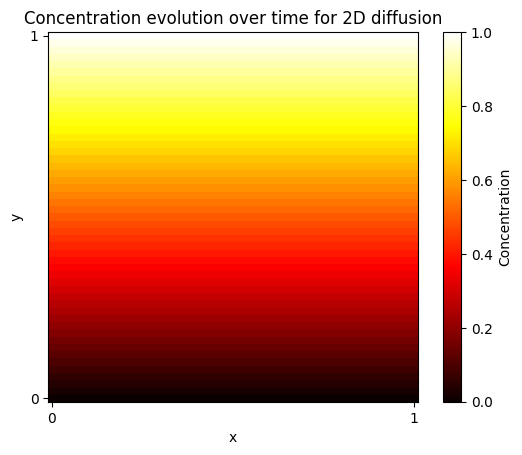

In [9]:
# Set up the figure
fig, ax = plt.subplots()
cax = ax.imshow(x[:, :, 0].T, cmap='hot', interpolation='nearest', origin='lower')
fig.colorbar(cax, label='Concentration')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xticks([0, N], ['0', str(L)])
ax.set_yticks([0, N], ['0', str(L)])
ax.set_title('Concentration evolution over time for 2D diffusion')

# Initialization function for FuncAnimation
def init():
    cax.set_data(np.zeros((L, L)).T)
    return cax,

# Animation function that FuncAnimation will call
def animate(i):
    cax.set_data(x[:, :, i].T)
    return cax,

# Create the animation object
ani = FuncAnimation(fig, animate, frames=x.shape[2], init_func=init, blit=True, repeat=False)

# Save the animation
ani.save('diffusion.mp4', writer='ffmpeg')
#ani.save('diffusion.gif', writer='pillow', fps=30)

# Display a message to the user with the output location
print("Animation saved as diffusion.gif")


### 1.3 The Time Independent Diffusion Equation

### 1.4 The Jacobi Iteration

In [70]:
def simulate_2D_diffusion_jacobi(x_0, epsilon = 10e-5):
    """
    Simulate the 2D diffusion using the Jacobi iteration method with a stopping condition.
    
    :param x_0: The initial concentration.
    :param epsilon: The convergence criterion.
    """
    time_steps = 10000

    c_current = init_concentration_matrix_2d(len(x_0), len(x_0))
    c_current[:,:] = x_0 # Initial condition at t=0
    c_next = c_current.copy()
    
    saved_matrices = []
    saved_matrices.append(c_current.copy())
    
    for k in range(1, time_steps):
        for i in range(1, c_current.shape[0] - 1):  # Skip the first and last rows which are boundary conditions
            for j in range(c_current.shape[1]):
                jp = (j + 1) % c_current.shape[1]  # If at the end, wrap to the beginning
                jm = (j - 1) % c_current.shape[1]  # If at the beginning, wrap to the end
                
                # Update the concentration based on neighboring points with periodic boundaries
                c_next[i, j] = 0.25 * (c_current[i+1, j] + c_current[i-1, j] +
                                    c_current[i, jp] + c_current[i, jm])

        if k % 10 == 0:  # Save every 10 iterations
            saved_matrices.append(c_next.copy())
        
        delta = np.max(np.abs(c_next - c_current))
        if delta < epsilon:
            print(f"Convergence reached at {k} iterations")
            break
        if k == time_steps-1:
            print(f"No convergence after max time steps {time_steps} and {k} iterations")
            break

        c_current[:, :] = c_next

    return saved_matrices, c_current, k

In [11]:
N = 50
x_0 = np.zeros((N+1, N+1), dtype=float)
x_0[:,-1] = 1
jacobi, cj, k = simulate_2D_diffusion_jacobi(x_0.T)

Convergence reached at 1863 iterations


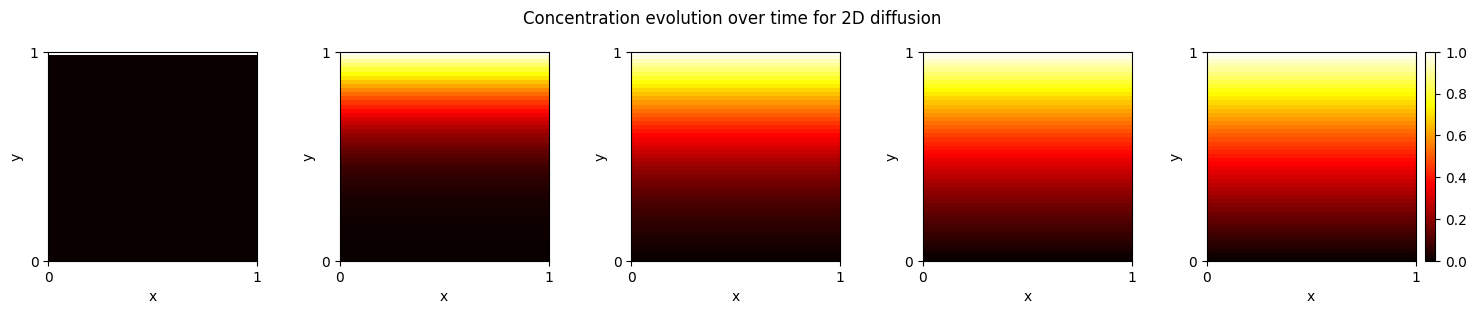

In [12]:
x = np.linspace(0, L, N+1)
y = np.linspace(0, L, N+1)
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))

for i, idx in enumerate([0,50,100,150,186]):
    im = ax[i].imshow(jacobi[idx], cmap='hot', interpolation='nearest', origin='lower', extent=[0, L, 0, L])
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('y')
    ax[i].set_xticks([0, L])
    ax[i].set_yticks([0, L])

# Add a colorbar to the last axis in the subplot
fig.colorbar(im, ax=ax[-1], fraction=0.046, pad=0.04)

fig.suptitle('Concentration evolution over time for 2D diffusion', fontsize=12)
plt.tight_layout()
plt.show()


### 1.5 The Gauss-Seidel Iteration

In [71]:
def simulate_2D_diffusion_gauss_seidel(x_0, epsilon = 10e-5):
    """
    Simulate the 2D diffusion using the Gauss-Seidel iteration method with a stopping condition.
 
    :param x_0: The initial concentration.
    :param epsilon: The convergence criterion.
    """
    time_steps = 10000
    
    c = init_concentration_matrix_2d(len(x_0), len(x_0))
    c[:,:] = x_0 # Initial condition at t=0
    
    saved_matrices = []
    saved_matrices.append(c.copy())

    for k in range(1, time_steps):
        c_old = c.copy()
        # Perform Gauss-Seidel iteration
        for i in range(1, c.shape[0] - 1):  # Skip the first and last rows which are boundary conditions
            for j in range(c.shape[1]):
                jp = (j + 1) % c.shape[1]  # If at the end, wrap to the beginning
                jm = (j - 1) % c.shape[1]  # If at the beginning, wrap to the end
                
                # Update the concentration based on neighboring points with periodic boundaries
                c[i, j] = 0.25 * (c[i+1, j] + c[i-1, j] + c[i, jp] + c[i, jm])
        
        if k % 10 == 0:  # Save every 10 iterations
            saved_matrices.append(c.copy())
        
        # Check for convergence
        delta = np.max(np.abs(c - c_old))
        if delta < epsilon:
            print(f"Convergence reached at {k} iterations")
            break
        if k == time_steps-1:
            print(f"No convergence after max time steps {time_steps} and {k} iterations")
            break
    
    return saved_matrices, c, k

Convergence reached at 1296 iterations


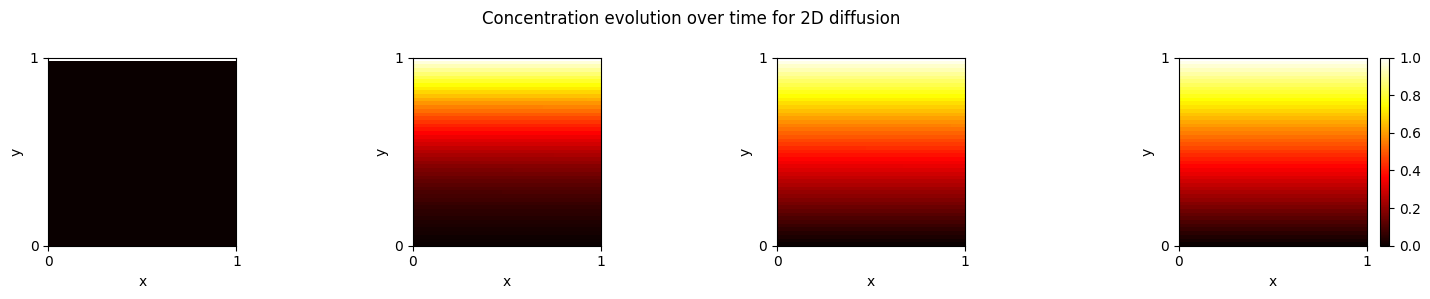

In [17]:
gauss, cg, k = simulate_2D_diffusion_gauss_seidel(x_0.T)

x = np.linspace(0, L, N+1)
y = np.linspace(0, L, N+1)
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 3))

for i, idx in enumerate([0,50,100,129]):
    im = ax[i].imshow(gauss[idx], cmap='hot', interpolation='nearest', origin='lower', extent=[0, L, 0, L])
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('y')
    ax[i].set_xticks([0, L])
    ax[i].set_yticks([0, L])

# Add a colorbar to the last axis in the subplot
fig.colorbar(im, ax=ax[-1], fraction=0.046, pad=0.04)

fig.suptitle('Concentration evolution over time for 2D diffusion', fontsize=12)
plt.tight_layout()
plt.show()


### 1.6 Successive Over Relaxation

In [72]:
def simulate_2D_diffusion_SOR(x_0, epsilon = 10e-5, omega=1.85):
    """
    Simulate the 2D diffusion using the Successive Over Relaxation (SOR) method with a stopping condition.

    :param x_0: The initial concentration.
    :param epsilon: The convergence criterion.
    :param omega: The relaxation parameter for SOR.
    """
    
    time_steps = 10000

    c = init_concentration_matrix_2d(len(x_0), len(x_0))
    c[:,:] = x_0 # Initial condition at t=0
    
    saved_matrices = []
    saved_matrices.append(c.copy())

    for k in range(1, time_steps):
        c_old = c.copy()
        # Perform SOR iteration
        for i in range(1, c.shape[0] - 1):  # Skip the first and last rows which are boundary conditions
            for j in range(c.shape[1]):
                jp = (j + 1) % c.shape[1]  # If at the end, wrap to the beginning
                jm = (j - 1) % c.shape[1]  # If at the beginning, wrap to the end
                
                # Update the concentration based on neighboring points with periodic boundaries
                c[i, j] = (omega/4) * (c[i+1, j] + c[i-1, j] + c[i, jp] + c[i, jm]) + (1 - omega) * c[i, j]
   
        if k % 10 == 0:  # Save every 10 iterations
            saved_matrices.append(c.copy())

        # Check for convergence
        delta = np.max(np.abs(c - c_old))
        if delta < epsilon:
            print(f"Convergence reached at {k} iterations")
            break
        if k == time_steps-1:
            print(f"No convergence after max time steps {time_steps}")
            break
    
    return saved_matrices, c, k

Convergence reached at 277 iterations


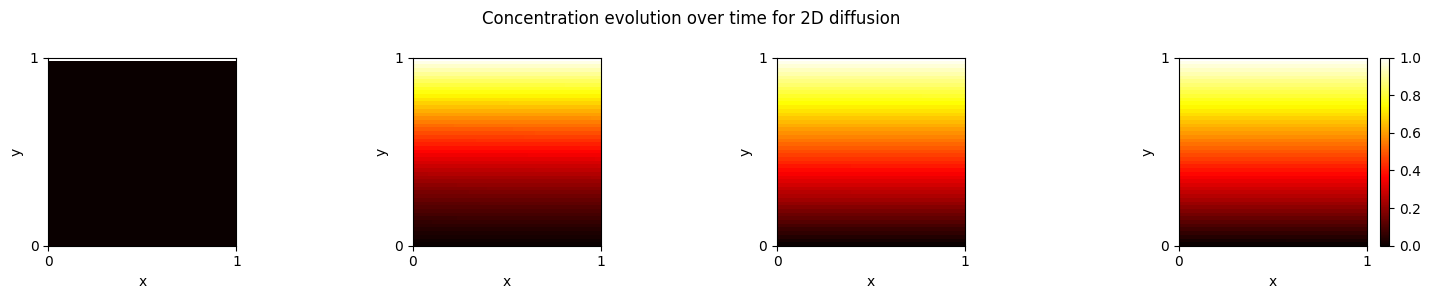

In [22]:
sor1, cs1, k = simulate_2D_diffusion_SOR(x_0.T, omega=1.80)

x = np.linspace(0, L, N+1)
y = np.linspace(0, L, N+1)
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 3))

for i, idx in enumerate([0,10,20,27]):
    im = ax[i].imshow(sor1[idx], cmap='hot', interpolation='nearest', origin='lower', extent=[0, L, 0, L])
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('y')
    ax[i].set_xticks([0, L])
    ax[i].set_yticks([0, L])

fig.colorbar(im, ax=ax[-1], fraction=0.046, pad=0.04)

fig.suptitle('Concentration evolution over time for 2D diffusion', fontsize=12)
plt.tight_layout()
plt.show()


#### H  
Implement the Jacobi iteration, the Gauss-Seidel method and SOR. Try N = 50. Test the methods by comparing the result to the analytical result in eq. (5), i.e. the linear dependence of the concentration on y.

In [117]:
N = 50
x_0 = np.zeros((N+1, N+1), dtype=float)
x_0[:,-1] = 1

In [47]:
y = np.arange(0, L+dx, dx)
ca = diffusion_2d_analytical(y, 1, D, 2)

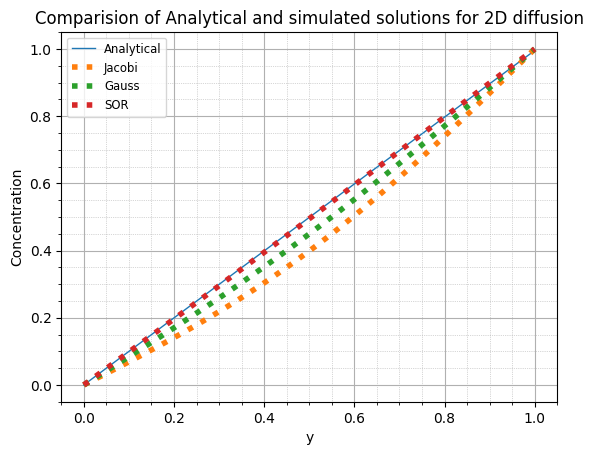

In [55]:
plt.figure()
plt.plot(y, ca, label = 'Analytical', linewidth=1)
plt.plot(y, cj[:, 1], linestyle='dotted', linewidth=4, label='Jacobi')
plt.plot(y, cg[:, 1], linestyle='dotted', linewidth=4, label='Gauss')
plt.plot(y, cs1[:, 1], linestyle='dotted', linewidth=4, label='SOR')

plt.legend(fontsize='small')
plt.ylabel('Concentration')
plt.xlabel('y')
plt.title('Comparision of Analytical and simulated solutions for 2D diffusion')
plt.grid(True)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.show()

#### I
Show how the convergence measure δ in eq. (14) depends on the number of iterations k for each of the methods. A log-lin plot may be suitable. For SOR, choose a few representative values for ω.

In [118]:
jacobi_iters = []
gauss_iters = []
sor_iters_80 = []
sor_iters_90 = []
sor_iters_85 = []

errors_jacobi = []
errors_gauss = []
errors_sor_90 = []

p_values = np.linspace(3, 9, num=6)  

for p in p_values:
    eps = 10**(-p)

    _, cj, jacobi_k = simulate_2D_diffusion_jacobi(x_0.T, epsilon=eps)
    jacobi_iters.append(jacobi_k)
    error_jacobi = np.max(np.abs(ca - cj[:, 1]))
    errors_jacobi.append(error_jacobi)

    _, cg, gauss_k = simulate_2D_diffusion_gauss_seidel(x_0.T, epsilon=eps)
    gauss_iters.append(gauss_k)
    error_gauss = np.max(np.abs(ca - cg[:, 1]))
    errors_gauss.append(error_gauss)
    
    _, _, sor_k1 = simulate_2D_diffusion_SOR(x_0.T, omega=1.80, epsilon=eps)
    sor_iters_80.append(sor_k1)

    _, _, sor_k2 = simulate_2D_diffusion_SOR(x_0.T, omega=1.85, epsilon=eps)
    sor_iters_85.append(sor_k2)

    _, cs, sor_k3 = simulate_2D_diffusion_SOR(x_0.T, omega=1.90, epsilon=eps)
    sor_iters_90.append(sor_k3)
    error_sor_90 = np.max(np.abs(ca - cs[:, 1]))
    errors_sor_90.append(error_sor_90)

Convergence reached at 243 iterations
Convergence reached at 251 iterations
Convergence reached at 150 iterations
Convergence reached at 126 iterations
Convergence reached at 97 iterations
Convergence reached at 2329 iterations
Convergence reached at 1529 iterations
Convergence reached at 302 iterations
Convergence reached at 234 iterations
Convergence reached at 162 iterations
Convergence reached at 5128 iterations
Convergence reached at 2929 iterations
Convergence reached at 454 iterations
Convergence reached at 343 iterations
Convergence reached at 228 iterations
Convergence reached at 7928 iterations
Convergence reached at 4329 iterations
Convergence reached at 607 iterations
Convergence reached at 452 iterations
Convergence reached at 293 iterations
No convergence after max time steps 10000 and 9999 iterations
Convergence reached at 5729 iterations
Convergence reached at 759 iterations
Convergence reached at 561 iterations
Convergence reached at 359 iterations
No convergence after

In [122]:
# errors_jacobi = []
# errors_gauss = []
errors_sor_90

[0.020877677324504407,
 0.004677734981047288,
 0.004677734981047288,
 0.004677734981047288,
 0.004677734981047288,
 0.004677734981047288]

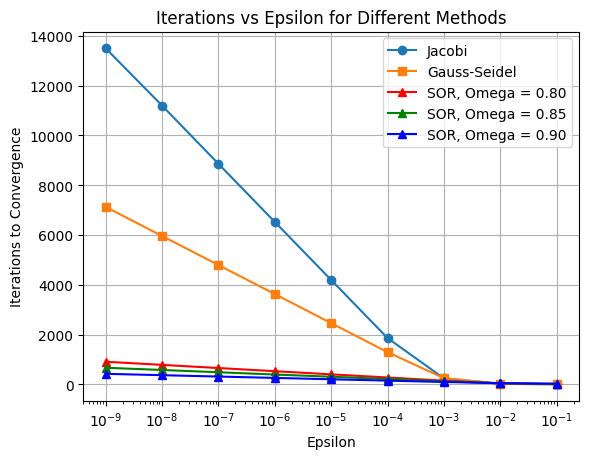

In [89]:
plt.figure()
plt.semilogx(epsilons, jacobi_iters, marker='o', label='Jacobi')
plt.semilogx(epsilons, gauss_iters, marker='s', label='Gauss-Seidel')
plt.semilogx(epsilons, sor_iters_80, marker='^', label='SOR, Omega = 1.80', color='r')
plt.semilogx(epsilons, sor_iters_85, marker='^', label='SOR, Omega = 1.85', color='g')
plt.semilogx(epsilons, sor_iters_90, marker='^', label='SOR, Omega = 1.90', color='b')

plt.xlabel('Epsilon')
plt.ylabel('Iterations to Convergence')
plt.title('Iterations vs Epsilon for Different Methods')
plt.legend()
plt.grid(True)
plt.show()

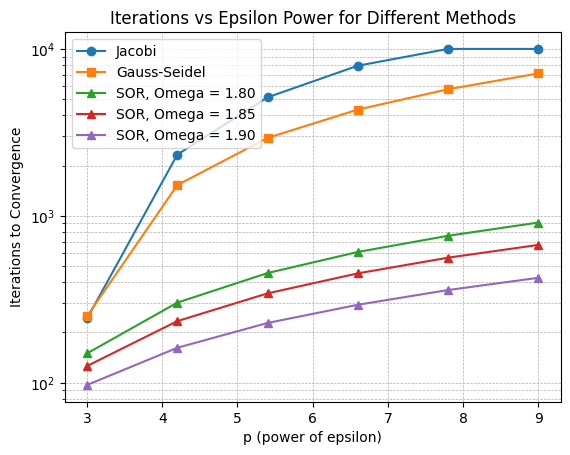

In [119]:
plt.figure()
plt.semilogy(p_values, jacobi_iters, marker='o', label='Jacobi')
plt.semilogy(p_values, gauss_iters, marker='s', label='Gauss-Seidel')
plt.semilogy(p_values, sor_iters_80, marker='^', label='SOR, Omega = 1.80')
plt.semilogy(p_values, sor_iters_85, marker='^', label='SOR, Omega = 1.85')
plt.semilogy(p_values, sor_iters_90, marker='^', label='SOR, Omega = 1.90')

plt.xlabel('p (power of epsilon)')
plt.ylabel('Iterations to Convergence')
plt.title('Iterations vs Epsilon Power for Different Methods')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()


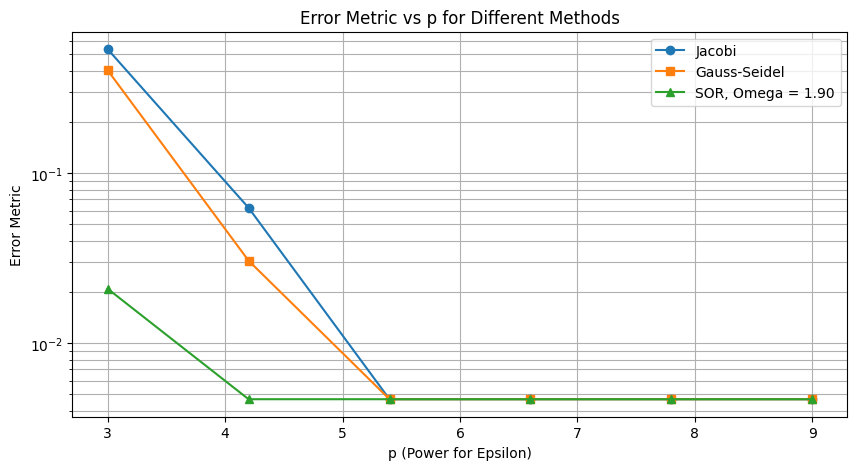

In [121]:
# Create a log-log plot of error metric vs p for each method
plt.figure(figsize=(10, 5))
plt.semilogy(p_values, errors_jacobi, marker='o', label='Jacobi')
plt.semilogy(p_values, errors_gauss, marker='s', label='Gauss-Seidel')
plt.semilogy(p_values, errors_sor_90, marker='^', label='SOR, Omega = 1.90')

plt.xlabel('p (Power for Epsilon)')
plt.ylabel('Error Metric')
plt.title('Error Metric vs p for Different Methods')
plt.legend()
plt.grid(True, which='both')
plt.show()


#### J
In the SOR method, find the optimal ω. How does it depend on N?.


[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9]
Convergence reached at 2423 iterations
Convergence reached at 2427 iterations
Convergence reached at 2420 iterations
Convergence reached at 2347 iterations
Convergence reached at 2192 iterations
Convergence reached at 2004 iterations
Convergence reached at 1812 iterations
Convergence reached at 1629 iterations
Convergence reached at 1456 iterations
Convergence reached at 1296 iterations
Convergence reached at 1146 iterations
Convergence reached at 1005 iterations
Convergence reached at 873 iterations
Convergence reached at 747 iterations
Convergence reached at 626 iterations
Convergence reached at 509 iterations
Convergence reached at 393 iterations
Convergence reached at 277 iterations


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Convergence reached at 151 iterations


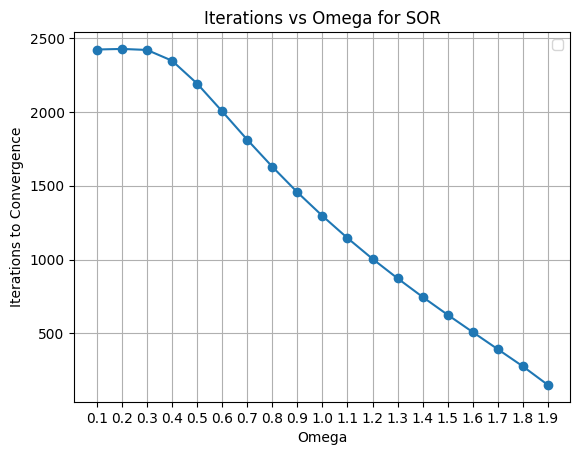

In [93]:
sor_k = []
omegas = np.arange(0.1,2,0.1)
print(omegas)

for o in omegas:
    _, _, k = simulate_2D_diffusion_SOR(x_0.T, omega=o)
    sor_k.append(k)

plt.figure()
plt.plot(omegas, sor_k, marker = 'o')
plt.xlabel('Omega')
plt.xticks(omegas)
plt.ylabel('Iterations to Convergence')
plt.title('Iterations vs Omega for SOR')
plt.grid(True)
plt.show()

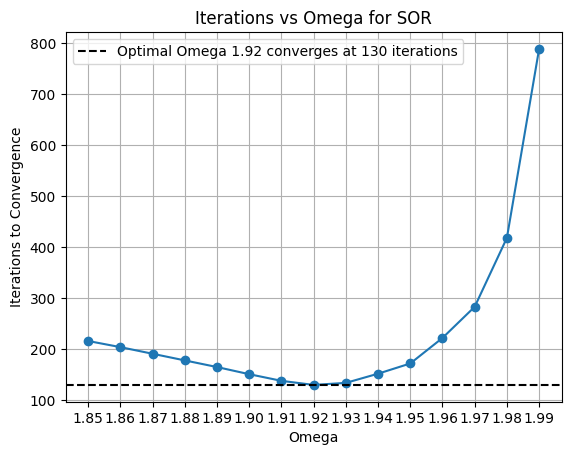

In [107]:
sor_k = []
omegas = np.arange(1.85,2.0,0.01)
print(omegas)

for o in omegas:
    _, _, k = simulate_2D_diffusion_SOR(x_0.T, omega=o)
    sor_k.append(k)

min_iterations = min(sor_k)
min_omega = omegas[sor_k.index(min_iterations)]

plt.figure()
plt.plot(omegas, sor_k, marker = 'o')
plt.axhline(y=min_iterations, color='black', linestyle='--', label=f'Optimal Omega 1.92 converges at {min_iterations} iterations')
plt.xlabel('Omega')
plt.xticks(omegas)
plt.ylabel('Iterations to Convergence')
plt.title('Iterations vs Omega for SOR')
plt.legend()
plt.grid(True)
plt.show()

Convergence reached at 595 iterations
Convergence reached at 360 iterations
Convergence reached at 112 iterations
Convergence reached at 1863 iterations
Convergence reached at 1296 iterations
Convergence reached at 130 iterations
Convergence reached at 2420 iterations
Convergence reached at 2359 iterations
Convergence reached at 385 iterations
Convergence reached at 2420 iterations
Convergence reached at 2445 iterations
Convergence reached at 702 iterations
Convergence reached at 2420 iterations
Convergence reached at 2445 iterations
Convergence reached at 1041 iterations


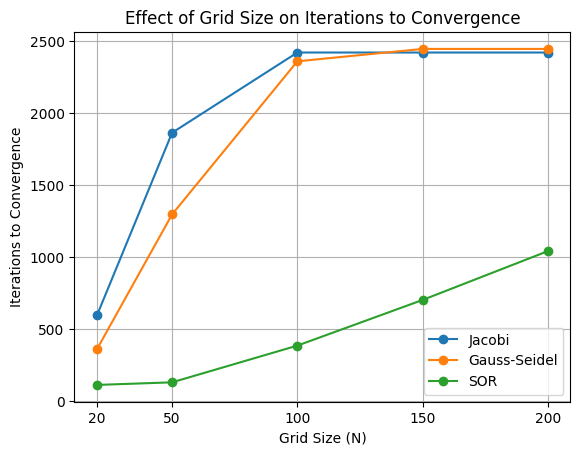

In [102]:
N_values = [20, 50, 100, 150, 200]
omegas = np.arange(1.85,2.0,0.01)

jacobi_iterations = []
gauss_iterations = []
sor_iterations = []

for N in N_values:
    x_0 = np.zeros((N+1, N+1), dtype=float)
    x_0[:,-1] = 1
    _,_,jacobi_iters = simulate_2D_diffusion_jacobi(x_0.T)
    _,_,gauss_iters = simulate_2D_diffusion_gauss_seidel(x_0.T)
    _,_,sor_iters = simulate_2D_diffusion_SOR(x_0.T, omega=1.92)

    jacobi_iterations.append(jacobi_iters)
    gauss_iterations.append(gauss_iters)
    sor_iterations.append(sor_iters)

plt.figure()
plt.plot(N_values, jacobi_iterations, marker='o', label='Jacobi')
plt.plot(N_values, gauss_iterations, marker='o', label='Gauss-Seidel')
plt.plot(N_values, sor_iterations, marker='o', label='SOR')

plt.xlabel('Grid Size (N)')
plt.ylabel('Iterations to Convergence')
plt.title('Effect of Grid Size on Iterations to Convergence')
plt.legend()
plt.grid(True)
plt.xticks(N_values)  # Ensure only the N values are marked on the x-axis
plt.show()

# Note that the time for every iteration drastically increases after 100 (obviously)
# - from few seconds per method to over a minute per method for convergence


Convergence reached at 59 iterations
Convergence reached at 57 iterations
Convergence reached at 55 iterations
Convergence reached at 56 iterations
Convergence reached at 58 iterations
Convergence reached at 62 iterations
Convergence reached at 63 iterations
Convergence reached at 69 iterations
Convergence reached at 76 iterations
Convergence reached at 85 iterations
Convergence reached at 99 iterations
Convergence reached at 106 iterations
Convergence reached at 112 iterations
Convergence reached at 129 iterations
Convergence reached at 158 iterations
Convergence reached at 179 iterations
Convergence reached at 222 iterations
Convergence reached at 286 iterations
Convergence reached at 433 iterations
Convergence reached at 862 iterations
Convergence reached at 277 iterations
Convergence reached at 265 iterations
Convergence reached at 253 iterations
Convergence reached at 241 iterations
Convergence reached at 229 iterations
Convergence reached at 216 iterations
Convergence reached at 

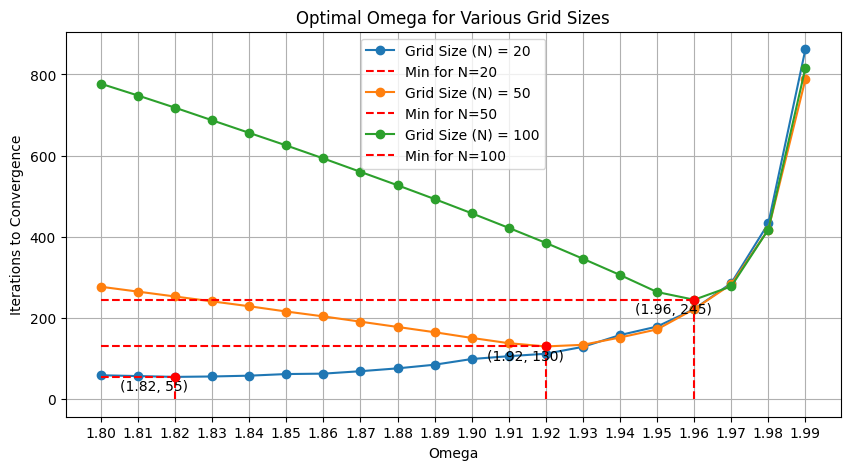

In [111]:
N_values = [20, 50, 100]
omegas = np.arange(1.80, 2.0, 0.01)

plt.figure(figsize=(10, 5))

for N in N_values:
    sor_N_vs_om = []
    x_0 = np.zeros((N+1, N+1), dtype=float)
    x_0[:,-1] = 1
    for o in omegas:
        _, _, k = simulate_2D_diffusion_SOR(x_0.T, omega=o)
        sor_N_vs_om.append(k)

    # Plot the current N vs omega
    plt.plot(omegas, sor_N_vs_om, marker='o', label=f'Grid Size (N) = {N}')
    
    # Find the minimum iterations and corresponding omega for the current N
    min_iterations = min(sor_N_vs_om)
    min_omega = omegas[sor_N_vs_om.index(min_iterations)]
    
    # Draw horizontal and vertical lines to the axes from the minimum point
    plt.hlines(y=min_iterations, xmin=omegas[0], xmax=min_omega, colors='r', linestyles='dashed', label=f'Min for N={N}')
    plt.vlines(x=min_omega, ymin=0, ymax=min_iterations, colors='r', linestyles='dashed')
    plt.scatter(min_omega, min_iterations, color='red', zorder=5)  # Place the dot on top of the line
    
    # Annotate the minimum point with its omega and iterations values
    plt.annotate(f'({min_omega:.2f}, {min_iterations})', (min_omega, min_iterations), textcoords="offset points", xytext=(-15,-10), ha='center')

plt.xlabel('Omega')
plt.xticks(np.round(omegas, 2))  # Round for better tick readability
plt.ylabel('Iterations to Convergence')
plt.title('Optimal Omega for Various Grid Sizes')
plt.legend()
plt.grid(True)
plt.show()


#### K  

Implement the possibility to include objects into the computational domain. The objects should be sinks. Experiment a little bit with some objects in the computational domain (e.g. a rectangle or a few rectangles, ...). What is the influence on the number of iterations. What about the optimal ω , is it influenced by the presence of objects? Look at the resulting concentration fields, and try to interpret what happens. The implementation in this exercise will also be used for diffusion-limited aggregation in Set 2.

Hint: For the iterations, the presence of the objects is not complicated. If a point (i, j) is part of an object, the concentration is just 0, and an iteration is not necessary (i.e., the new value is also 0). Therefore, you must implement some easy encoding of the object in the computational grid, and during the iterations simply test if the grid point that you are updating is part of the object or not. If not, you apply the SOR rule, if yes, just put the new value to zero. The easiest encoding is just an extra array of integers, where e.g. a one-value would code for the presence of an object, and a zero value for the absence of an object.


In [70]:
def simulate_2D_diffusion_with_sinks(D, L, T, dt, dx, x_0, sinks):
    """
    Simulate the 2D diffusion with the given parameters.
    param D: The diffusion coefficient.
    param L: The length of the domain.
    param T: The total time to simulate.
    param dt: The time step.
    param dx: The space step.
    param x_0: The initial concentration.
    param sinks: A list of tuples, where each tuple contains two tuples. The first tuple contains the start and end indices of the x coordinate of the sink, and the diffusion constant D.    
    """
    if ((4 * dt * D) / (dx**2)) > 1:
        print((4 * dt * D) / (dx**2))
        raise ValueError("The given parameters will result in an unstable solution. Please use a smaller time step or a larger space step.")
    time_steps = np.arange(0, T+dt, dt)
    x = np.zeros((len(x_0), len(x_0), len(time_steps)), dtype=float) # Create an array to store the results.
    D = np.full((len(x_0), len(x_0)), D)
    for sink in sinks:
        D[sink[0][0]:sink[0][1], sink[1][0]:sink[1][1]] = sink[2]
    x[:,-1,:] = 1 # Set the boundary condition at y=L.
    x[:,0,:] = 0 # Set the boundary condition at y=0.
    x[:,:,0] = x_0 # Set the initial condition.
    # Assuming periodic boundary conditions at x=0 and x=L.
    for k in range(1, len(time_steps)):
        x[:, 1:-1, k] = x[:, 1:-1, k-1] + ((D[:,1:-1] * dt) / (dx**2)) * (np.roll(x[:, 1:-1, k-1],-1,axis=0) + np.roll(x[:, 1:-1, k-1],1,axis=0) + x[:, 2:, k-1] + x[:, 0:-2, k-1] - 4*x[:, 1:-1, k-1])
        # for sink in sinks:
        #     x[sink[0][0]:sink[0][1], sink[1][0]:sink[1][1], k] = 0

    return x


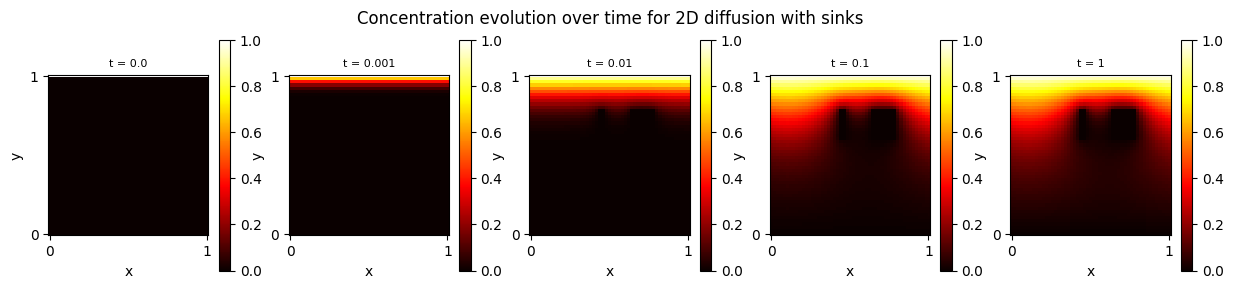

In [86]:
# define the parameters
D = 1
L = 1
T = 1
# need to experiment with the time step and space step to get a stable solution.
dt = 0.0001
N = 50
dx = L/N
x_0 = np.zeros((N+1, N+1), dtype=float)
x_0[:, -1] = 1
sinks = [((22,24),(30,40),0.4),((32,40),(30,40),0.8)]

x = simulate_2D_diffusion_with_sinks(D, L, T, dt, dx, x_0,sinks)

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=5,figsize=(15, 3))
for i,t in enumerate([0.0, 0.001, 0.01, 0.1, 1]):
    im = ax[i].imshow(x[:,:,int(t/dt)].T, cmap='hot', interpolation='nearest', origin='lower')
    fig.colorbar(im, ax=ax[i])
    #fig.colorbar(im, ax=ax[i], label='Concentration'
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('y')
    ax[i].set_xticks([0, N], ['0', str(L)])
    ax[i].set_yticks([0, N], ['0', str(L)])
    ax[i].set_title('t = {}'.format(t), fontsize=8)

fig.suptitle('Concentration evolution over time for 2D diffusion with sinks', fontsize=12)
plt.show()


#### Optional

Think of a way to incorporate objects with insulating material in your domain. What changes in the time evolution of the system? And in the final state?